# Import of all libraries

In [10]:
#Import of all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import tensorflow as tf
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras.optimizers import adam_v2
from PIL import Image
import mlflow

In [11]:
labels_all = pd.read_csv('archive/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
breeds_all = labels_all['breed']
all_classes = breeds_all.unique()
breed_count = breeds_all.value_counts() # number of time you find all values
print(len(breed_count))
breed_count.head()

120


breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64

In [13]:
class_names = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed']).isin(class_names)]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [14]:
#creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32') # 3 -> RGB
#one hot encoding
Y_data = label_binarize(labels['breed'], classes= class_names)

# Reading and converting image to numpy array and normalizeing dataset
for i in tqdm(range(len(labels))): #tqdm progress bar of your loop
    img = Image.open('archive/train/%s.jpg' % labels['id'][i])
    img = img.resize((224, 224)) # Resize the image to target size
    img_array = np.array(img)
    x = np.expand_dims(img_array.copy(),axis=0) # expand the dimension or size to (1, 224, 224, 3) instead of (224, 224, 3)
    X_data[i] = x / 255.0 # divide by 255 because we want value of RGB to be between 0 and 1

# Printing train image and one hot encode shape & size
print('\nTrain Images shapes: ', X_data.shape, ' size: {:,} '.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,'size: {:,}'.format(Y_data.size)) # in {} we put parameters



  0%|          | 0/357 [00:00<?, ?it/s]

100%|██████████| 357/357 [00:04<00:00, 77.59it/s] 


Train Images shapes:  (357, 224, 224, 3)  size: 53,738,496 
One-hot encoded output shape:  (357, 3) size: 1,071


In [15]:
# Building the model

model = Sequential()

model.add(Conv2D(filters= 64, kernel_size= (5, 5), activation= 'relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 32, kernel_size= (3,3), activation= 'relu', kernel_regularizer= 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 16, kernel_size=(7,7), activation= 'relu', kernel_regularizer= 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 8, kernel_size=(5,5), activation= 'relu', kernel_regularizer= 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer= 'l2'))
model.add(Dense(64, activation= 'relu', kernel_regularizer= 'l2'))
model.add(Dense(len(class_names), activation= 'softmax'))
opt= tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer= opt,metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 16)      

In [16]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size= 0.1)
# Splitting the training data set into a training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size= 0.2) 

In [17]:
# Training the model
epochs = 10
batch_size = 128

history = model.fit(X_train,Y_train, batch_size= batch_size, epochs= epochs, validation_data= (X_val, Y_val))

Epoch 1/10
2/2 [==============================] - 55s 25s/step - loss: 4.8354 - accuracy: 0.3438 - val_loss: 4.6528 - val_accuracy: 0.4308
Epoch 2/10
2/2 [==============================] - 45s 18s/step - loss: 4.5879 - accuracy: 0.4375 - val_loss: 4.4244 - val_accuracy: 0.3692
Epoch 3/10
2/2 [==============================] - 32s 17s/step - loss: 4.3506 - accuracy: 0.4336 - val_loss: 4.1867 - val_accuracy: 0.4769
Epoch 4/10
2/2 [==============================] - 33s 17s/step - loss: 4.1103 - accuracy: 0.5117 - val_loss: 3.9655 - val_accuracy: 0.5077
Epoch 5/10
2/2 [==============================] - 36s 17s/step - loss: 3.9127 - accuracy: 0.5234 - val_loss: 3.7427 - val_accuracy: 0.5692
Epoch 6/10
2/2 [==============================] - 33s 17s/step - loss: 3.6944 - accuracy: 0.5898 - val_loss: 3.5243 - val_accuracy: 0.5538
Epoch 7/10
2/2 [==============================] - 33s 17s/step - loss: 3.5218 - accuracy: 0.6055 - val_loss: 3.4344 - val_accuracy: 0.5692
Epoch 8/10
2/2 [===========

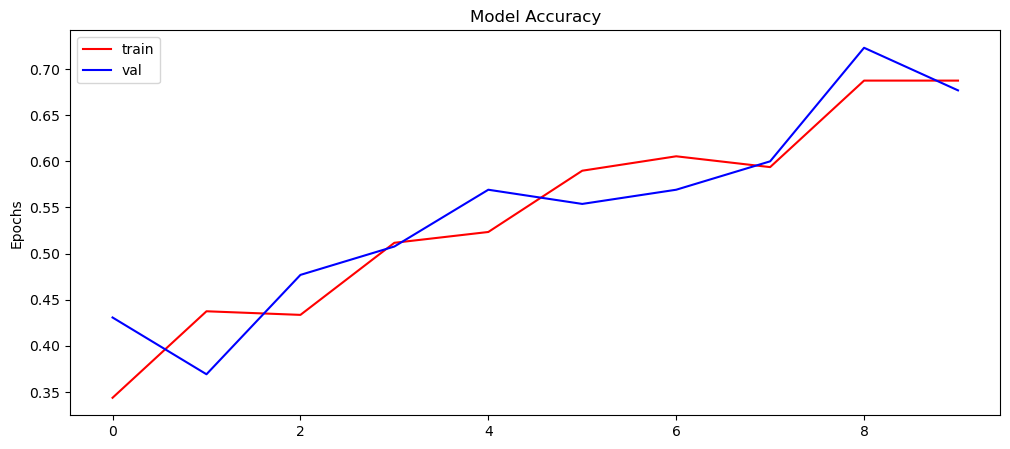

In [18]:
# Plot the training history

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model Accuracy')
plt.ylabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [19]:
#Prediction accuracy 
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)

print('Accuracy over the test set: \n', round((score[1]*100), 2), '%')

2/2 [==============================] - 1s 99ms/step - loss: 2.7958 - accuracy: 0.7500
Accuracy over the test set: 
 75.0 %


Originally :  scottish_deerhound
Predicted :  scottish_deerhound


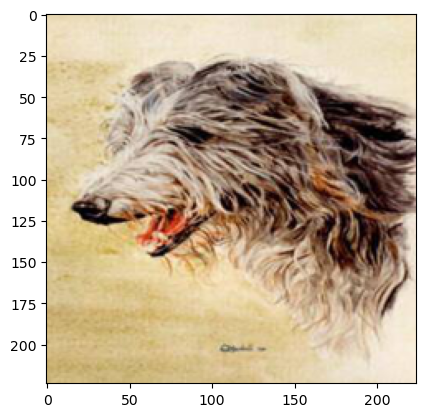

In [20]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show

#finding max value from prédiction list and comparing original to predicted
print("Originally : ", labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ", labels['breed'][np.argmax(Y_pred[1])])

In [21]:
#Export your model 
model.save("dog_breed.h5")

In [24]:
import mlflow.keras


def mlflow_run(model, X, y, name):

    with mlflow.start_run() as run:
        run_id = run.info.run_id
        mlflow.set_tag("run_id", run_id)
        pred = model.predict(X)
        score = model.evaluate(X, y)
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("loss", "categorical_crossentropy")
        mlflow.log_param("epochs", 10)

        # Log the TensorFlow model
        mlflow.keras.log_model(model, "model")

        mlflow.log_metric("Accuracy", score[1])

        mlflow.end_run()
    

mlflow_run(model=model, X=X_test, y=Y_test, name="test")

2/2 [==============================] - 2s 247ms/step - loss: 2.7958 - accuracy: 0.7500


MlflowException: Got invalid value [2.7957603931427, 0.75] for metric 'Accuracy' (timestamp=1716398002761). Please specify value as a valid double (64-bit floating point)